# PSU DS 200 Section 1
# Fall 2024
# Lab 10 Train Decision Tree-based Sentiment Classifier for ChatGPT Tweets

## Instructor: Dr. John Yen
## LAs: Lauren Miller, Aaron Almeida, Amiera Masheetah Binti Irwan Rizalman, and Sharifah Rodziah Hanim BintiSyed Alwi

## First, upload the data file (ChatGPTtweets.csv) into your Google Drive (same directory DS200F24 as Lab 9) before you execute code cells of this Notebook.

## Total 6 Problems:
- Problem 1: 0.5 point
- Problem 2: 0.5 point
- Problem 3: 1 point
- Problem 4: 1 point
- Problem 5: 1 point

## Total: 4 points

## Due: 11:59 pm, November 6, 2024
## Early Submission: 11:59 pm, November 3, 2024 (10% bonus)

## Learning Objectives

In this lab, you will learn to be able to do the following:
- Extract texts/tweets associated with different labels to compute their size.
- Transform the labels into integers ("good" --> 1, "bad" --> 0), which are required for most machine learning models.
- Split text and labels into a training set and a testing set.
- Use **CountVectorizer** in **sklearn** to create a word frequency matrix of training text.
- Learn a decision tree model for classifying tweets about ChatGPT into "positive" (class 1) or "negative" (class 0).
- Choose the hyper-parameters for decision tree learning (**max_depth** and **min_samples_leaf**)
- Evaluate how good is the model (for prediction) using testing data (not used for training the model).  This is important to reduce
the risk of **overfitting**, which is an important concept we will elaborate in a future lab.
- Interpret the decision tree model by explaining the impact of a feature test on a given decision tree in terms of (1) how the likelihood of positive sentiment (or negative sentiment) of a tweet changes for the True branch, and (2) how the likelihood of positive sentiment (or negative sentiment) of a tweet changes if it falls on the False branch.

In [1]:
import datascience
import numpy as np
import graphviz

from datascience import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.base import ClassifierMixin

import pandas as pd
import numpy as np

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/My\ Drive/DS200F24/

Ben-NE-9-10-2015-pass.csv  Ben_pass_vx_10_22_Ex3  Ben_pass_vx_10_22_Ex3.pdf  ChatGPTtweets.csv


In [4]:
path1="/content/drive/My Drive/DS200F24/ChatGPTtweets.csv"

In [5]:
tweets = Table.read_table(path1, sep =',')

In [6]:
tweets.show(5)

Unnamed: 0,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialogue https:/ ...,neutral
1,"Try talking with ChatGPT, our new AI system which is opt ...",good
2,ChatGPT: Optimizing Language Models for Dialogue https:/ ...,neutral
3,"THRILLED to share that ChatGPT, our new model optimized ...",good
4,"As of 2 minutes ago, @OpenAI released their new ChatGPT. ...",bad


In [7]:
tweets_positive = tweets.where('labels', are.equal_to('good'))
tweets_negative = tweets.where('labels', are.equal_to('bad'))
tweets_neutral = tweets.where('labels', are.equal_to('neutral'))

In [8]:
tweets_positive.show(2)

Unnamed: 0,tweets,labels
1,"Try talking with ChatGPT, our new AI system which is opt ...",good
3,"THRILLED to share that ChatGPT, our new model optimized ...",good


In [9]:
tweets_negative.show(2)

Unnamed: 0,tweets,labels
4,"As of 2 minutes ago, @OpenAI released their new ChatGPT. ...",bad
6,"As of 2 minutes ago, @OpenAI released their new ChatGPT. ...",bad


In [10]:
tweets_positive.num_rows

56011

In [11]:
tweets_negative.num_rows

107796

# Mapping Sentiment Labels to Integer Labels
Most of the machine learning algorithms expect the "class labels" in the training data to be an integer.  In the case of binary classification, the convention is class 1 is the class of interest.  For example, we used class 1 in Lab 9 for completed plass.  
- In this lab, we use class 1 for "good" (positive) sentiment regarding ChatGPT.  
- To use the dataset to demonstrate binary sentiment classification, we will only use tweets labelled "good" and "bad".  
- After you complete the lab, you
are welcomed to use the dataset to construct a 3-class classification of
tweets.  In that case, you will use class 2 for "good", class 1 for "neutral", and class 0 for "bad".  The choice of the integer for each label is based on the distance between the labels.  For example, the difference between "good" and "bad" is larger than the distance between "good" and "neutral".  Therefore, the integer index of "neutral" should be between that of "good" and "bad".

## \<Table\>.with_column(\<column heading\>, \<column value\>)

The **with_column** method of a Table object returns a new table with an additional column. Because it is easier to add a column with a common values, we will use this approach to add the column with integer
sentiment label to the subtable containing only positive tweets (tweets_positive)
and the subtable containing only negative tweets (tweets_negative).

In [12]:
tweets_positive_index = tweets_positive.with_column("sentiment", 1)

In [13]:
tweets_positive_index.show(2)

Unnamed: 0,tweets,labels,sentiment
1,"Try talking with ChatGPT, our new AI system which is opt ...",good,1
3,"THRILLED to share that ChatGPT, our new model optimized ...",good,1


In [14]:
tweets_negative_index = tweets_negative.with_column("sentiment", 0)

In [15]:
tweets_negative_index.show(2)

Unnamed: 0,tweets,labels,sentiment
4,"As of 2 minutes ago, @OpenAI released their new ChatGPT. ...",bad,0
6,"As of 2 minutes ago, @OpenAI released their new ChatGPT. ...",bad,0


# Balancing Labelled Data to Reduce Potential Bias due to Unballanced Class Distribution

One of the sources of 'bias' in a machine learning model is the unballanced class distribution.
- A set of labelled data for binary classification is said to be **unballanced** if the size of data in one class is much larger than the size of the data in the other class.



## Problem 1 (0.5 points)
Is the dataset for sentiment classification of ChatGPT-related tweets balanced or unbalanced? Explain your answer.

## Solution for Problem 1:
Yes, the dataset for sentiment classification is unbalanced. The amount of tweets labelled as negative is around twice the amount of positive tweets.

# Create a balanced labelled dataset using subsampling
- Subsampling: Sample a subset of the majority class (i.e., the label that has more labelled data than the other lables) so that the size of data for different class labels are about the same.

In [16]:
sample_size = 50000

In [17]:
positive_samples = tweets_positive_index.sample(sample_size).select("tweets", "sentiment")

In [18]:
positive_samples.show(2)

tweets,sentiment
"ChatGPT, and AI in general, is going to change the lands ...",1
"ChatGPT, give me an idea for content creation because I’ ...",1


In [19]:
negative_samples = tweets_negative_index.sample(sample_size).select("tweets", "sentiment")

In [20]:
negative_samples.show(2)

tweets,sentiment
Time to pack it up.\n\n#chatgpt\n\nhttps://t.co/TxsCC7va ...,0
OpenAI's new ChatGPT bot: 10 coolest things you can do w ...,0


In [21]:
data = positive_samples.append(negative_samples)

In [22]:
data.show(5)

tweets,sentiment
"ChatGPT, and AI in general, is going to change the lands ...",1
"ChatGPT, give me an idea for content creation because I’ ...",1
.@JosephPera ChatGPT joke in your style and it's ummm be ...,1
ChatGPT is definitely better at explaining song meanings ...,1
Is anyone having a pleasant time to chat with ChatGPT? I ...,1


In [23]:
X = data.column("tweets")

In [24]:
print(X)

[ "ChatGPT, and AI in general, is going to change the landscape for education \\n\\nIt's just getting too damn good\\n\\nI see institutions utilizing their own advanced AI to detect auto generated content\\n\\nIs this going to create a workforce of people who don't know what they're doing?"
 'ChatGPT, give me an idea for content creation because I’m a fucking fish in a barrel when it comes to creativity.'
 ".@JosephPera ChatGPT joke in your style and it's ummm beautiful https://t.co/AZWAj4Va02"
 ...,
 'What methods can be used to deliver the token code to a user who is configured to use two-factor authentication? pregunta del examen NSE4, contestada correctamente por IA ChatGPT.'
 "I keep ending up in the AI rabbit hole just by going about my life. Stack overflow has put out a notice that you can't use AI generated solutions from chatGPT to answer coding questions\\n\\nIf AI users want to be anti-people, just get off the fucking internet, or stay in your corner"
 'Often Arabic speakers

In [25]:
Y = data.column("sentiment")

In [26]:
print(Y)

[1 1 1 ..., 0 0 0]


In [27]:
Y

array([1, 1, 1, ..., 0, 0, 0])

# Split the Labelled Data into a Training Set and a Testing Set
Like Lab 9, we need to split the labelled tweets into a training set and a testing set.  Typical choice of test_size is from 0.1 to 0.25.  
- In anoter word, we typically use 75% (or more) of the labelled data to train the model, then evaluate it using the remaining labelled data.  
- We typically save at least 10% of the labelled data for testing.

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size = 0.2, random_state = 100)

In [29]:
X.size

100000

In [30]:
Y.size

100000

In [31]:
X_train.size

80000

In [32]:
X_test.size

20000

In [33]:
print(Y_test)

[1 1 1 ..., 0 0 1]


In [34]:
np.sum(Y_test)

10068

In [35]:
np.sum(Y_train)

39932

In [36]:
Y_train.size

80000

In [37]:
print(X_train)

['s/o to chatGPT fr'
 "Large language models will threaten many types of apps. Even in places where you wouldn't think #AI makes a difference. All it'll take is enough people to have access to an open source model. &gt;\\n\\nA New Chat Bot Is a ‘Code Red’ for Google’s Search Business https://t.co/k9sC3O7mIg"
 '#ChatGPT is insanely powerful.\\nTry it out here: https://t.co/aau4DotfxU \\n\\nPretty much convincing how AI is changing the world.\\n\\nKudos @sama'
 ...,
 "oh that's wild 😲\\n\\n#ChatGPT https://t.co/FmM8V65BX1 https://t.co/2yc438pRzb"
 'I asked ChatGPT why you should learn to program Python, here is what it said: #pythonprogramming'
 'This ChatGPT thing is ideal for mass producing disinformation in troll farms. In fact, it is one of the best use cases for it. https://t.co/4wcFdP4TKx']


In [38]:
print(X_test)

[ 'Top programming to learn in 2023 by chatGPT .\\n1. Python\\n2. Java\\n3.C++\\n4.JavaScript\\n5. C#\\n#chatbot #AIchatbot #GP #GPT3 #programming #coding #developer #tech #softwareengineering https://t.co/EeFTFrr3YC'
 'I used ChatGPT from OpenAI this morning to ask some questions about #DecisionEducation. Here are the unedited questions and answers... wow!\\n@AllDecisionEd @AnnieDuke \\n\\nhttps://t.co/m3wqlvdlMT'
 'Forgot how to do this and #ChatGPT came to the rescue. https://t.co/glU2sRbosS'
 ..., 'ChatGPT replying to your prompt \\n\\n https://t.co/QyYUu0K9NG'
 'Generative AI is progressing furiously—and educators need to catch up fast, @StephenMarche writes. https://t.co/vJ4JiHZWie'
 'Write a product requirement document for retaining new visitors to Twitch. \\n\\nAI likely to replace many of the PMs and SDE jobs first given the wealth of trainable data. Imagine a large model trained on Amazon 6-pagers &amp; Google/FB product specs, and GitHub code.\\n@OpenAI #ChatGPT https://t.c

# Use ``CountVectorizer`` in ``sklearn`` to transform input texts into its word frequency matrix representation.
- A mapping from tokens (in the input text) to index (in the word frequency matrix) is created.  The mapping is a Python dictionary, which stores (key, value) pairs.
- The parameter ``lowercase`` in ``CountVectorizer``, if is set to True, convert input tokens to lowercases.  For example, "Penn State" is converted to "penn state''.  Otherwise, "Penn" and "penn" will be treated as two distinct tokens/words.
- The parameter ``min_df`` specifies the minimum time a word occurs in the input text (e.g., input tweets in this lab) that is required for the word to be included in the word frequency representation of the input.
- Increasing the value of ``min_df`` from 1 (default value) to a slightly larger threshold (say 5) reduces the number of words/tokens considered for
training a sentiment classifier by ignoring words that occur rarely (i.e., below the threshold).

In [50]:
text = [ 'ChatGPT is great.', 'ChatGPT sucks!', 'How to verify the answers of chatgpt?']

In [57]:
CV = CountVectorizer(lowercase= True, min_df = 1)

In [58]:
WF = CV.fit_transform(text)

In [42]:
tokens = CV.get_feature_names_out()

In [43]:
print(tokens)

['answers' 'chatgpt' 'great' 'how' 'is' 'of' 'sucks' 'the' 'to' 'verify']


In [44]:
print(WF.toarray())

[[0 1 1 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [1 1 0 1 0 1 0 1 1 1]]


In [45]:
test_text = [ 'Does ChatGPT have answers for everything?', 'What is new about ChatGPT or generative AI?']

In [46]:
test_WF = CV.transform(test_text)

In [47]:
print(test_WF.toarray())

[[1 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]]


# Problem 2 (0.5 point)
What words in the first tweet of test_tweet are NOT represented by the Word Frequency Matrix?
Why?

# Answer to Problem 2:
If the question is referring to the test_text. The Word Frequency Matrix does not include the words "great", "how", "is", "of", "sucks", "the", "to" and "verify". These words simply do not appear in the first tweet. Therefore, they do not satisfy the min_df threshold and do not show up in the matrix.


# Choice of Min_df
### The model we want to build may not suffer from ignoring words that are very rare.  However, ignoring them can have a benefit: it can reduce the total number of words needed for Word Frequency Matrix.

### In the example below, we choose min_df to be 5.  In another word, we ignore words that occur less than 5 times.

In [59]:
count_vect = CountVectorizer(lowercase=True, min_df = 5)

In [60]:
train_tweets_WF = count_vect.fit_transform(X_train)

In [62]:
clf = tree.DecisionTreeClassifier(criterion='entropy', random_state = 100, max_depth=15, \
                                  min_samples_leaf = 0.0001)
clf.fit(train_tweets_WF, Y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=15,
                       min_samples_leaf=0.0001, random_state=100)

# Evaluate the Decision Tree for Sentiment Classification Using Testing Tweets



In [63]:
test_tweets_WF = count_vect.transform(X_test)
Y_test_predict = clf.predict(test_tweets_WF)

In [64]:
precision = precision_score(Y_test, Y_test_predict)

In [65]:
print("Precision is ", precision)

Precision is  0.808299955496


In [66]:
recall = recall_score(Y_test, Y_test_predict)

In [67]:
print("Recall is ", recall)

Recall is  0.721593166468


In [68]:
f1 = f1_score(Y_test, Y_test_predict)

In [69]:
print("F1 score is ", f1)

F1 score is  0.762489504618


# Generate the confusion matrix of the model's performance on testing data.

# Problem 3 (1 point)
- (a) Complete the code below to generate a confusion matrix for evaluating the decision tree's performance on testing data.
- (b) Based on the confusion matrix, how many testing samples are true positive, true negative, false positive, and false negative, respecitvely.
# Answer for Problem 3 (b):
-- True Positive: 7265
-- True Negative: 8209
-- False Positive: 1723
-- False Negative: 2803

In [70]:
confusion_matrix(Y_test, Y_test_predict)

array([[8209, 1723],
       [2803, 7265]])

# Generate a Visualization of the Decision Tree Learned

In [71]:
dot_data= tree.export_graphviz(clf, out_file=None, feature_names=count_vect.get_feature_names_out() )

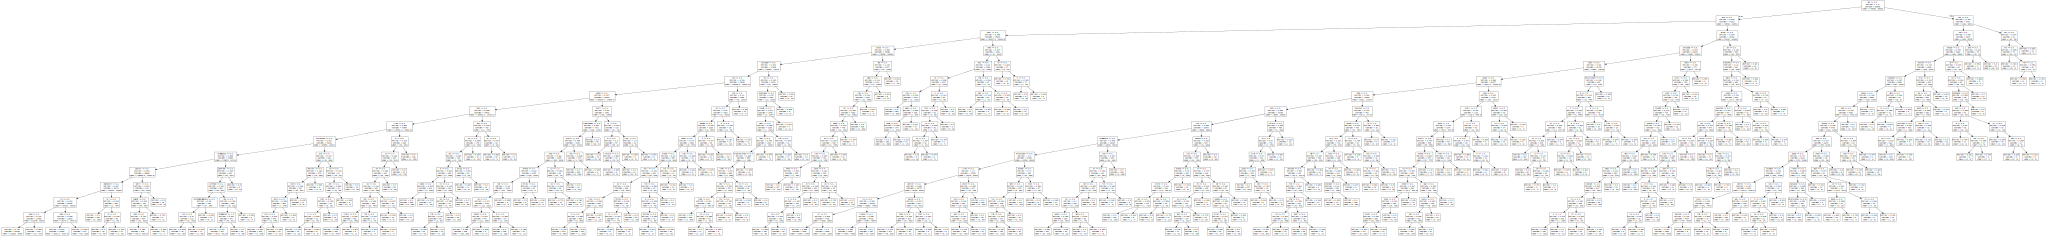

In [72]:
graph = graphviz.Source(dot_data)
graph

# Problem 4 (1 points)
Save the decision tree in a file named ast "sentiment_classifier_P4", followed by your first initial and your least name. Submit this decision tree visualization file together with the completed Juptyer Notebook for this lab.

In [73]:
path3='/content/drive/My Drive/DS200F24/sentiment_classifier_P4_vxu'
graph.render(path3)

'/content/drive/My Drive/DS200F24/sentiment_classifier_P4_vxu.pdf'

# Problem 5 (1 points)
Find a node in the tree that tests the word frequency of the word "wow" and the word "impressive".  For each test, explains (a) what is the probability of a tweet that falls on the True Branch (i.e., not containing the word) having a positive sentiment, and (b) what is the probability of a tweet that falls on the False Branch (i.e., containing the word) to have positive sentiment.

# Answers to Problem 5:
- For the node testing the word "wow"
-- (a) The probability for a positive sentiment falling on the True Branch is 5266/26798 or 19.7%
-- (b) For positive sentiment on the False Branch, the probability is 271/284 or 95.4%
For the node testing the word "impressive"
-- (a) The probability for a positive sentiment falling on the True Branch is 8434/17209 or 49.0%
-- (b) For positive sentiment on the False Branch, the probability is 385/395 or 97.5%